In [2]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [3]:
import os
import urllib.request
import zipfile
import tarfile

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import numpy as np

In [4]:
data_dir = "/Users/akipin/opt/data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [5]:
import sklearn
print(sklearn.__version__)

0.21.3


In [6]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, data_home="/Users/akipin/opt/data/")

In [7]:
X = mnist.data
y = mnist.target

この画像データのラベルは5です


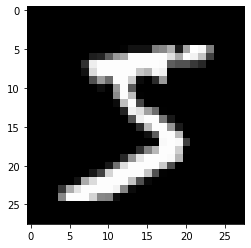

In [8]:
plt.imshow(X[0].reshape(28, 28), cmap='gray')
print("この画像データのラベルは{}です".format(y[0]))

In [9]:
data_dir_path = "/Users/akipin/opt/data/img_78/"
if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

In [26]:
count7=0
count8=0
max_num=200  # 画像は200枚ずつ作成する

for i in range(len(X)):
    
    # 画像7の作成
    if (y[i] is "7") and (count7<max_num):
        file_path="/Users/akipin/opt/data/img_78/img_7_"+str(count7)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 画像を28×28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64に拡大
        pil_img_f.save(file_path)  # 保存
        count7+=1 
    
    # 画像8の作成
    if (y[i] is "8") and (count8<max_num):
        file_path="/Users/akipin/opt/data/img_78/img_8_"+str(count8)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 画像を28*28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64に拡大
        pil_img_f.save(file_path)  # 保存
        count8+=1 

In [11]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [12]:
input = torch.tensor([[[[1., 1.], [2., 2.]]]])
print("入力データ")
print(input)
print("-----")

print("通常の畳み込み")
m = nn.Conv2d(1, 1, 2, stride=1, bias=False)
m.weight[0, 0, 0, 0] = 1
m.weight[0, 0, 0, 1] = 2
m.weight[0, 0, 1, 0] = 3
m.weight[0, 0, 1, 1] = 4
print("カーネル")
print(m.weight)
print("出力")
print(m(input))

print("-----")
print("転置読み込み")
m = nn.ConvTranspose2d(1, 1, 2, stride=1, bias=False)
m.weight[0, 0, 0, 0] = 1
m.weight[0, 0, 0, 1] = 2
m.weight[0, 0, 1, 0] = 3
m.weight[0, 0, 1, 1] = 4
print("カーネル")
print(m.weight)
print("出力")
print(m(input))

入力データ
tensor([[[[1., 1.],
          [2., 2.]]]])
-----
通常の畳み込み
カーネル
Parameter containing:
tensor([[[[1., 2.],
          [3., 4.]]]], grad_fn=<CopySlices>)
出力
tensor([[[[17.]]]], grad_fn=<MkldnnConvolutionBackward>)
-----
転置読み込み
カーネル
Parameter containing:
tensor([[[[1., 2.],
          [3., 4.]]]], grad_fn=<CopySlices>)
出力
tensor([[[[ 1.,  3.,  2.],
          [ 5., 13.,  8.],
          [ 6., 14.,  8.]]]], grad_fn=<SlowConvTranspose2DBackward>)


In [14]:
#Generatorの実装
class Generator(nn.Module):
    
    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8, kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))
        
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))
        
        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1), nn.Tanh())
    
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

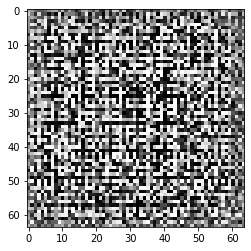

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

input_z = torch.randn(1, 20)

input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

fake_images = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

In [18]:
#Discriminatorの実装
class Discriminator(nn.Module):
    
    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size * 4, image_size * 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.last = nn.Conv2d(image_size * 8, 1, kernel_size=4, stride=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

In [19]:
D = Discriminator(z_dim=20, image_size=64)

input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

d_out = D(fake_images)

print(nn.Sigmoid()(d_out))

tensor([[[[0.5052]]]], grad_fn=<SigmoidBackward>)


In [20]:
mini_batch_size = 2
label_real = torch.full((mini_batch_size,), 1)

label_fake = torch.full((mini_batch_size,), 0)

criterion = nn.BCEWithLogitsLoss(reduction='mean')

d_out_real = D(x)

input_z = torch.randn(mini_batch_size, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
d_out_fake = D(fake_images)

d_loss_real = criterion(d_out_real.view(-1), label_real)
d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
d_loss = d_loss_real + d_loss_fake

NameError: name 'x' is not defined

In [21]:
input_z = torch.randn(mini_batch_size, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
d_out_fake = D(fake_images)

g_loss = criterion(d_out_fake.view(-1), label_real)

In [28]:
def make_datapath_list():
    
    train_img_list = list()
    
    for img_idx in range(200):
        img_path = "/Users/akipin/opt/data/img_78/img_7_" + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
        img_path = "/Users/akipin/opt/data/img_78/img_8_" + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
    return train_img_list

In [29]:
class ImageTransform():
    
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        
    def __call__(self, img):
        return self.data_transform(img)

In [30]:
class GAN_Img_Dataset(data.Dataset):
    
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img)
        
        return img_transformed

In [31]:
train_img_list = make_datapath_list()

mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

batch_iterator = iter(train_dataloader)
imges = next(batch_iterator)
print(imges.size())

torch.Size([64, 1, 64, 64])


In [33]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        #Conv2d, ConvTransの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
G.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")

ネットワークの初期化完了


In [38]:
def train_model(G, D, dataloader, num_epochs):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス", device)
    
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])
    
    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    z_dim = 20
    mini_batch_size = 64
    
    G.to(device)
    D.to(device)
    
    G.train()
    D.train()
    
    torch.backends.cudnn.benchmark = True
    
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    
    iteration = 1
    logs = []
    
    for epoch in range(num_epochs):
        
        t_epoch_start = time.time()
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0
        
        print('--------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('--------------')
        print('(train)')
        
        for imges in dataloader:
            #Discriminatorの学習
            if imges.size()[0] == 1:
                continue
                
            imges = imges.to(device)
                
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)
            
            #真の画像の判定
            d_out_real = D(imges)
            
            #偽の画像の生成と判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)
            
            #誤差の計算
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake
            
            #バックプロゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            
            d_loss.backward()
            d_optimizer.step()
            
            #Generatorの学習
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)
            
            g_loss = criterion(d_out_fake.view(-1), label_real)
            
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            
            #記録
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1
            
        t_epoch_finish = time.time()
        print('---------')
        print('epoch {} || Epoch_D_Loss:{:.4f} || Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer: {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()
    return G, D

In [39]:
num_epochs = 200
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs)

使用デバイス cpu
--------------
Epoch 0/200
--------------
(train)


RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 画像生成
fake_images = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')